Sorry pour le nom du notebook

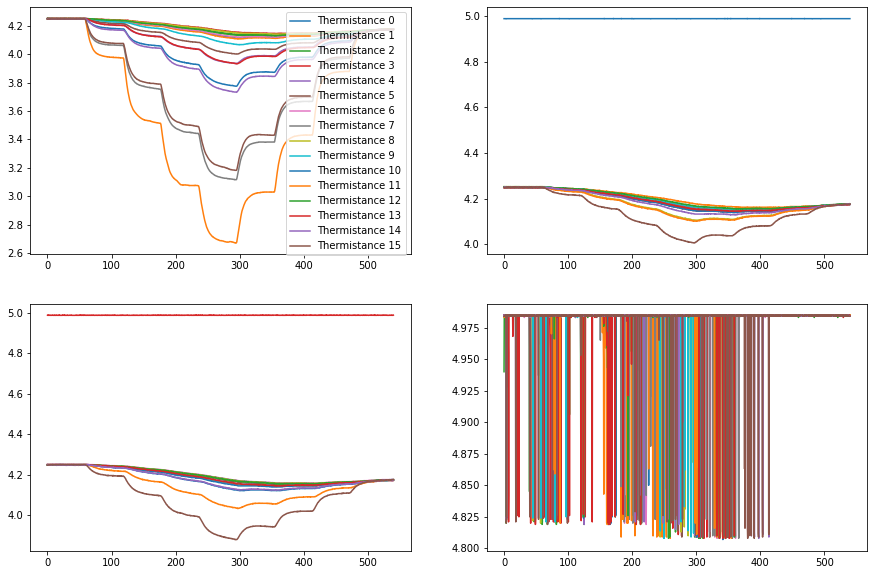

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from utils import *
current_dir = os.curdir
dataPath = current_dir + "/vrai_test_escalier_17_avril.txt"


indiceMux1 = [43, 42, 41, 40, 24, 23, 22, 10, 39, 21, 9, 3, 20, 8, 2, 1]
indiceMux2 = [101, 102, 37, 38, 59, 36, 58, 57, 19, 56, 35, 18, 55, 34, 17, 7]
indiceMux3 = [16, 33, 54, 32, 53, 31, 52, 51, 50, 30, 15, 6, 49, 29, 14, 5]
indiceMux4 = [103, 104, 105, 4, 13, 28, 48, 11, 12, 27, 47, 46, 45, 26, 44, 25]

time, mux1, mux2, mux3, mux4 = datas(dataPath)
indiceAberant = indicesAberant(indiceMux1, indiceMux2, indiceMux3, indiceMux4, mux1, mux2, mux3, mux4)
indiceDansMux4 = indiceAberantDansMux4(indiceAberant, indiceMux4)

fig, ax = plt.subplots(2,2 , figsize=(15, 10))
for i, x in enumerate(mux1):
	ax[0][0].plot(time, x, label="Thermistance " + str(i))
	ax[0][1].plot(time, mux2[i])
	ax[1][0].plot(time, mux3[i])
	ax[1][1].plot(time, mux4[i])

ax[0][0].legend()
plt.show()

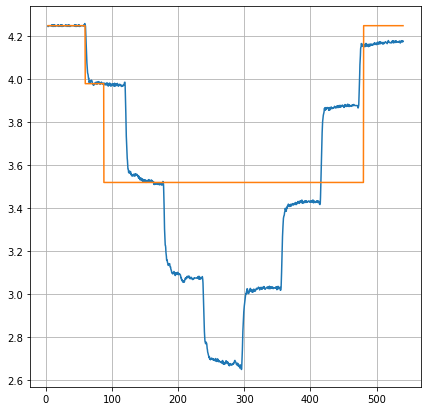

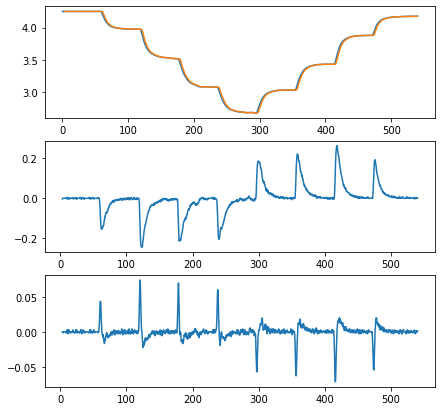

In [2]:
maxvalue = mux1[11]
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 7))
fig, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].plot(time, maxvalue)

def derivative(x, delta = 5):
    """ 
    Return dx/dy
    x : array of values
    return : array of derivative values
    """
    x = np.array(x)
    return (x[delta:] - x[:-delta])

def predictive_algo(x, c, d, delta):
    """ 
    Return x ,c * dy/dx , d * d2x/dy2
    x : array of values
    c : array of coefficients
    d : delta of coefficients
    return : array of predicted values
    """
    x = np.array(x)
    return x[5:-5], c * derivative(x, delta[0])[3:-2], d * derivative(derivative(x, delta[1]), delta[2])

deltas = [5, 5, 5]



prediction = predictive_algo(maxvalue, 3.5, -1.4, deltas)
realvalues = np.ones(len(prediction[0]-10))*4.25
realvalues[160:-170] = 3.98
realvalues[240:-170] = 3.52

ax1.plot(time[10:], prediction[0] + prediction[1] + prediction[2])
ax1.plot(time[10:], realvalues)
ax1.grid()
ax[0].plot(time[10:], prediction[0])
ax[1].plot(time[10:], prediction[1])
ax[2].plot(time[10:], prediction[2])

In [32]:
dataPath = current_dir + "/DataLabo2_2023-04-18.txt"
#skip first line, and use tab as separator

data = pd.read_csv(dataPath, sep = "\t", skiprows = 1, header = None)

In [33]:
#add column names
columns = ["time", "power", "x", "y", "tension", 'temp',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
            '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
            '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
            '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59']
data.columns = columns
#set time as index
data = data.set_index("time")
#change type from str to float where , is replaced by .
data = data.replace(',','.', regex=True)
data = data.astype(float)

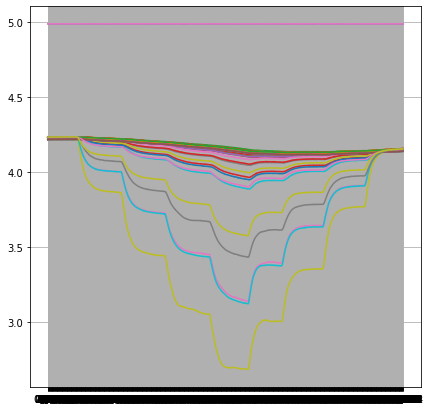

In [58]:
tensions = np.array(data.iloc[:, 5:])
#get min value in tensions and get indezx
minvalue = np.min(tensions)
minindex = np.argmin(tensions)
#plot the column with the min value
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.plot(data.index, tensions)
ax.grid()